<a href="https://colab.research.google.com/github/Freddsle/ML_Blindness_Detection/blob/yuliya/code/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> collab

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Data

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:
- **0 - No DR**
- **1 - Mild**
- **2 - Moderate**
- **3 - Severe**
- **4 - Proliferative DR**

Images may contain artifacts, be out of focus, underexposed, or overexposed. 

- train.csv - the training labels
- test.csv - the test set (you must predict the diagnosis value for these variables)
- sample_submission.csv - a sample submission file in the correct format
- train.zip - the training set images
- test.zip - the public test set images

Dowload directly from kaggle (kaggle.json is needed for API - put it in `/content/`):

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [01:21<00:00, 138MB/s]
100% 9.51G/9.51G [01:21<00:00, 125MB/s]


In [ ]:
! unzip aptos2019-blindness-detection
! rm aptos2019-blindness-detection.zip

Archive:  aptos2019-blindness-detection.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_images/0005cfc8afb6.png  
  inflating: test_images/003f0afdcd15.png  
  inflating: test_images/006efc72b638.png  
  inflating: test_images/00836aaacf06.png  
  inflating: test_images/009245722fa4.png  
  inflating: test_images/009c019a7309.png  
  inflating: test_images/010d915e229a.png  
  inflating: test_images/0111b949947e.png  
  inflating: test_images/01499815e469.png  
  inflating: test_images/0167076e7089.png  
  inflating: test_images/01c31b10ab99.png  
  inflating: test_images/01c5ba195207.png  
  inflating: test_images/01e4d86b3a30.png  
  inflating: test_images/020921b796d5.png  
  inflating: test_images/020f6983114d.png  
  inflating: test_images/021c207614d6.png  
  inflating: test_images/0229c0a80d42.png  
  inflating: test_images/024d0a225db1.png  
  inflating: test_images/0268f4382c67.png  
  inflating: test_images/0299d97f31f7.png  


# EDA

In [ ]:
train_dir = os.path.join('.','train_images/')
df = pd.read_csv(os.path.join('.', 'train.csv'))

df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe

df.head(10)

In [ ]:
len_df = len(df)
print(f"There are {len_df} images in df.")

The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.

In [ ]:
df.diagnosis.value_counts() 

In [ ]:
df['diagnosis'].hist(figsize = (10, 5))

Example image:

In [ ]:
from PIL import Image

im = Image.open(df['path'][1])
width, height = im.size
print(width,height) 
im.show()

In [ ]:
plt.imshow(np.asarray(im))

Is the number of chanels always 3? - yes

In [ ]:
# long run
for i in range(len_df):
    img = np.array(Image.open(df['path'][i])).shape
    
    if img[2] != 3:
      print(img)

# Load data (another way)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

In [ ]:
RESCALE_SIZE = 224, 224
BATCH_SIZE = 64

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 15, 10

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.25,
                                    stratify=df.diagnosis)


train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [ ]:
class BlindDataset(Dataset):
    def __init__(self, df, mode="train") -> None:
        super().__init__()

        self.df = df
        self.len_ = len(self.df.path)
        self.mode = mode

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomRotation(degrees=180),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])
        
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])

        tensor_image = self.load_sample(self.df.path[index])
        tensor_image = transform(tensor_image)

        return tensor_image, self.df.diagnosis[index]

In [ ]:
trainset = BlindDataset(train_df)
valset = BlindDataset(val_df, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

### Класс для тренировки и валидации

In [ ]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
      
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)              
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)
    
    return predictions, targ


def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score
    
    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

# Learn
## vgg19

In [ ]:
import torchvision
from torch import nn

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
N_CLASSES = 5
num_features = 25088
model.classifier = nn.Linear(num_features, N_CLASSES)
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, 
                  DEVICE, accuracy_score)
trainer.fit()

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 1 out of 10: Train loss = 0.9087867722954861, validation loss = 1.1660371581713358 
                                         Train metric = 0.3630735615440641, validation metric = 0.29912663755458513

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 2 out of 10: Train loss = 0.6372950569141743, validation loss = 0.6673643390337626 
                                         Train metric = 0.49854333576110704, validation metric = 0.47707423580786024

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 3 out of 10: Train loss = 0.5577227500982063, validation loss = 0.6554173032442728 
                                         Train metric = 0.5273124544792426, validation metric = 0.5436681222707423

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 4 out of 10: Train loss = 0.5472664209299309, validation loss = 0.5703351298967997 
                                         Trai

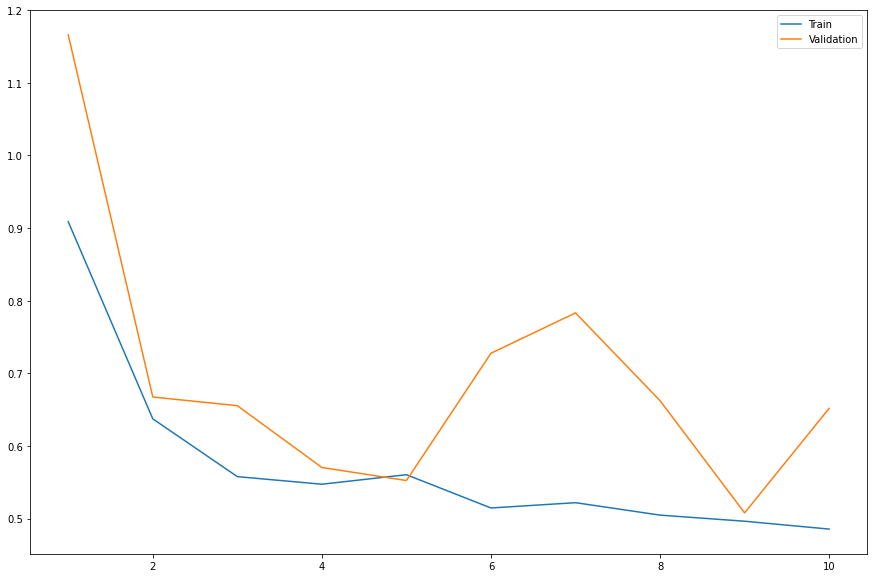

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [ ]:
calculate_metric(model, valloader)

0.7379912663755459

In [ ]:
from functools import partial

f1_macro = partial(f1_score, average="macro")
f1_micro = partial(f1_score, average="micro")

In [ ]:
calculate_metric(model, valloader, f1_macro)

0.5182825940928282

In [ ]:
calculate_metric(model, valloader, f1_micro)

0.7379912663755459

## DenseNet169

In [ ]:
model = torchvision.models.densenet169(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

In [ ]:
N_CLASSES = 5
num_features = 1664
model.classifier = nn.Linear(num_features, N_CLASSES)
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, 
                  DEVICE, accuracy_score)
trainer.fit()

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 1 out of 10: Train loss = 0.7168778867222542, validation loss = 0.7023934801419576 
                                         Train metric = 0.39257101238164605, validation metric = 0.3700873362445415

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 2 out of 10: Train loss = 0.544572785150173, validation loss = 0.5332439263661702 
                                         Train metric = 0.44865258557902404, validation metric = 0.4334061135371179

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 3 out of 10: Train loss = 0.5151101693857548, validation loss = 0.5420120060443878 
                                         Train metric = 0.45957756737072103, validation metric = 0.4868995633187773

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 4 out of 10: Train loss = 0.5023924736089485, validation loss = 0.6332627574602763 
                                         Train

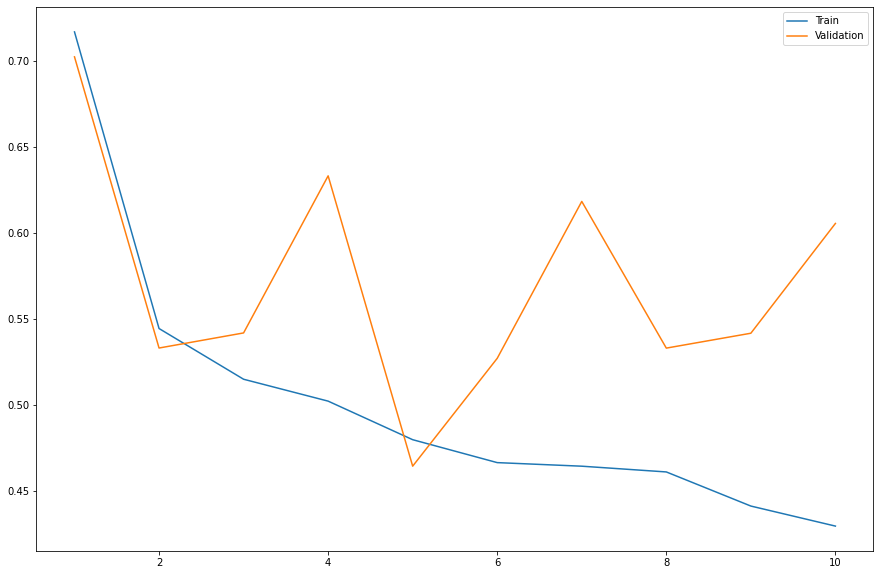

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [ ]:
calculate_metric(model, valloader)

0.7609170305676856

In [ ]:
calculate_metric(model, valloader, f1_macro)

0.6183316356759928

In [ ]:
calculate_metric(model, valloader, f1_micro)

0.7609170305676856